In [1]:
# Pick up package from parent folder
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import sklearn
from sklearn import metrics
from sklearn.datasets import load_boston, load_diabetes
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.utils.multiclass import unique_labels
import time

import gensim.downloader as model_api

import ordinal
from ordinal import OrderedProbitRanker
from ordinal import OrderedLogitRanker

import AppReviews # generate review data from app store
import docembedding

# Training prepro

In [3]:
df = pd.read_csv("app_reviews.csv")
df.rating = df.rating.astype(int)
df.head(5)

,app_name,title,version,rating,review,vote_count
0,Tomb of the Mask,Overall fun game...but,1.6,2,ENOUGH of the ads. I know the creator wants to...,0.0
1,Tomb of the Mask,Would be good if not for the ads,1.6,1,"Everything you do requires an ad, it’s really ...",0.0
2,Tomb of the Mask,AMAZING,1.6,5,This game is so indicting and I love it,0.0
3,Tomb of the Mask,So many ads,1.6,4,The game itself is really fun but you go throu...,0.0
4,Tomb of the Mask,Terrible app,1.6,1,This app has a cool game in it. However the ap...,0.0


In [4]:
model = model_api.load("glove-wiki-gigaword-300")

dft = df.join(pd.get_dummies(df.app_name, drop_first=True, dummy_na=True))

# Add embedding components
for col in ['title', 'review']:
    tokens = docembedding.stringprocessing.tokenize(dft[col], lower=True, split=True)
    weights = docembedding.embedding.getWordWeights(tokens, "tf-idf")
    embeds = docembedding.embedding.sentenceEmbedding(tokens, model, weights)
    embeds = pd.DataFrame(embeds)
    embeds.columns = [col + str(colnum) for colnum in embeds.columns]
    dft = dft.join(embeds)
dft = dft.drop(['version', 'vote_count', 'review', 'title', 'app_name'], 1)
dft.head(3)

,rating,Google Maps - GPS Navigation,Google Maps - Transit & Food,Hello Stars,Messenger,Tomb of the Mask,Ultra Sharp,nan,title0,title1,...,review290,review291,review292,review293,review294,review295,review296,review297,review298,review299
0,2,0,0,0,0,1,0,0,0.008337,0.359944,...,0.011253,-0.144465,-0.039978,0.146787,0.108508,-0.151146,0.080810,-0.069745,-0.002517,-0.003518
1,1,0,0,0,0,1,0,0,-0.146053,0.298234,...,0.024687,-0.224383,-0.130395,0.051382,0.121735,0.026025,0.077560,-0.115350,0.008827,-0.006115
2,5,0,0,0,0,1,0,0,0.149990,0.053597,...,-0.153915,-0.110484,-0.303880,0.008504,0.138842,-0.395003,0.191106,-0.088626,0.061870,0.016231


In [ ]:
X = dft.drop('rating', 1)
y = dft.rating

In [ ]:
def fitscore(model, X, y):
    start = time.time()
    model.fit(X, y)
    pred_val = model.predict(X)
    pred_proba = model.predict_proba(X)
    print("time: ", time.time() - start)
    print("score: ", metrics.accuracy_score(y, pred_val))
    print("mse: ", metrics.mean_squared_error(y, pred_val))
    print("mae: ", metrics.mean_absolute_error(y, pred_val))
    pd.Series(pred_val).hist(bins=5)

In [ ]:
y.hist(bins=5)

time:  14.814236640930176
score:  0.6763732065540369
mse:  1.4724509720689363
mae:  0.6029374310213091


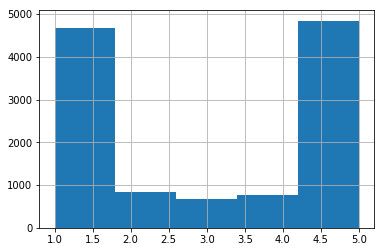

In [ ]:
lr = sklearn.linear_model.LogisticRegression(C=9999, solver='lbfgs', multi_class='auto', max_iter=10000)
fitscore(lr, X, y)

time:  7.106756210327148
score:  0.5492826216147381
mse:  1.2074879021988285
mae:  0.6604125986925885


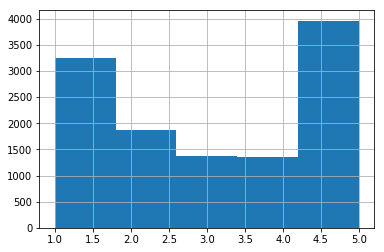

In [ ]:
lat = OrderedLogitRanker(alpha=1, verbose=1, variant='at')
fitscore(lat, X, y)

time:  8.234502792358398
score:  0.45148145003820356
mse:  1.1612191187706935
mae:  0.7313014687155106


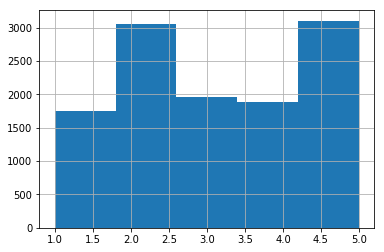

In [ ]:
lse = OrderedLogitRanker(alpha=1, verbose=1,  variant='se')
fitscore(lse, X, y)

In [ ]:
opr = OrderedProbitRanker(method='L-BFGS-B', use_grad=False)
fitscore(opr, X, y)